# Neural Networks for Handwritten Digit Recognition, Binary

Goal: use a neural network to recognize the hand-written digits zero and one.

## 1 - Packages 

In [63]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from autils import *
%matplotlib inline

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

<a name="2"></a>
## 2 - Neural Networks


### 2.1 Problem Statement

Use a neural network to recognize two handwritten digits, zero and one. This is a binary classification task. Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks. 

<a name="2.2"></a>
### 2.2 Dataset

- The `load_data()` function shown below loads the data into variables `X` and `y`


- The data set contains 1000 training examples of handwritten digits $^1$, here limited to zero and one.  

    - Each training example is a 20-pixel x 20-pixel grayscale image of the digit. 
        - Each pixel is represented by a floating-point number indicating the grayscale intensity at that location. 
        - The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. 
        - Each training example becomes a single row in our data matrix `X`. 
        - This gives us a 1000 x 400 matrix `X` where every row is a training example of a handwritten digit image.

$$X = 
\left(\begin{array}{cc} 
--- (x^{(1)}) --- \\
--- (x^{(2)}) --- \\
\vdots \\ 
--- (x^{(m)}) --- 
\end{array}\right)$$ 

- The second part of the training set is a 1000 x 1 dimensional vector `y` that contains labels for the training set
    - `y = 0` if the image is of the digit `0`, `y = 1` if the image is of the digit `1`.

$^1$<sub> This is a subset of the MNIST handwritten digit dataset (http://yann.lecun.com/exdb/mnist/)</sub>

In [64]:
# load dataset
X, y = load_data()

#### 2.2.1 View the variables

In [65]:
print ('The first element of X is: ', X[0])

The first element of X is:  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+

In [66]:
print ('The first element of y is: ', y[0,0])
print ('The last element of y is: ', y[-1,0])

The first element of y is:  0
The last element of y is:  1


<a name="toc_89367_2.2.2"></a>
#### 2.2.2 Check the dimensions of your variables

In [67]:
print ('The shape of X is: ' + str(X.shape))
print ('The shape of y is: ' + str(y.shape))

The shape of X is: (1000, 400)
The shape of y is: (1000, 1)


#### 2.2.3 Visualizing the Data

The code randomly selects 64 rows from `X`, maps each row back to a 20 pixel by 20 pixel grayscale image and displays the images together. The label for each image is displayed above the image 

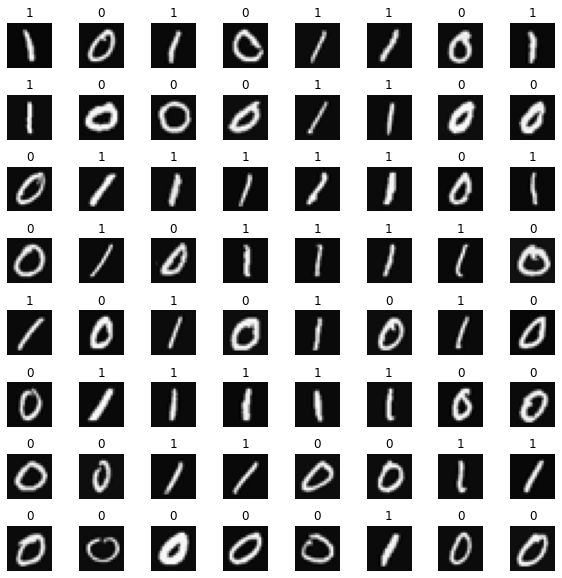

In [68]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# You do not need to modify anything in this cell

m, n = X.shape

fig, axes = plt.subplots(8,8, figsize=(8,8))
fig.tight_layout(pad=0.1)

for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20,20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
    
    # Display the label above the image
    ax.set_title(y[random_index,0])
    ax.set_axis_off()

<a name="2.3"></a>
### 2.3 Model representation

The neural network you will use in this assignment is shown in the figure below. 
- This has three dense layers with sigmoid activations.
    - Recall that our inputs are pixel values of digit images.
    - Since the images are of size $20\times20$, this gives us $400$ inputs  

- The parameters have dimensions that are sized for a neural network with $25$ units in layer 1, $15$ units in layer 2 and $1$ output unit in layer 3. 
  
- Therefore, the shapes of `W`, and `b`,  are 
        - layer1: The shape of `W1` is (400, 25) and the shape of `b1` is (25,)
        - layer2: The shape of `W2` is (25, 15) and the shape of `b2` is: (15,)
        - layer3: The shape of `W3` is (15, 1) and the shape of `b3` is: (1,)
>**Note:** The bias vector `b` could be represented as a 1-D (n,) or 2-D (1,n) array. Tensorflow utilizes a 1-D representation and this lab will maintain that convention. 
               

<a name="2.4"></a>
### 2.4 Tensorflow Model Implementation


Tensorflow models are built layer by layer. A layer's input dimensions ($s_{in}$ above) are calculated for you. You specify a layer's *output dimensions* and this determines the next layer's input dimension. The input dimension of the first layer is derived from the size of the input data specified in the `model.fit` statement below. 
>**Note:** It is also possible to add an input layer that specifies the input dimension of the first layer. For example:  
`tf.keras.Input(shape=(400,)),    #specify input shape`  
We will include that here to illuminate some model sizing.

Use Keras [Sequential model] and [Dense Layer] with a sigmoid activation to construct the network.

In [69]:
model = Sequential(
    [               
        tf.keras.Input(shape=(400,)),    #specify input size
        Dense(25, activation='sigmoid'),
        Dense(15, activation='sigmoid'),
        Dense(1,  activation='sigmoid')
    ], name = "my_model" 
)                            

In [70]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 25)                10025     
                                                                 
 dense_10 (Dense)            (None, 15)                390       
                                                                 
 dense_11 (Dense)            (None, 1)                 16        
                                                                 
Total params: 10,431
Trainable params: 10,431
Non-trainable params: 0
_________________________________________________________________


In [71]:
# UNIT TESTS
from public_tests import *

test_c1(model)

All tests passed!


The parameter counts shown in the summary correspond to the number of elements in the weight and bias arrays as shown below.

In [72]:
L1_num_params = 400 * 25 + 25  # W1 parameters  + b1 parameters
L2_num_params = 25 * 15 + 15   # W2 parameters  + b2 parameters
L3_num_params = 15 * 1 + 1     # W3 parameters  + b3 parameters
print("L1 params = ", L1_num_params, ", L2 params = ", L2_num_params, ",  L3 params = ", L3_num_params )

L1 params =  10025 , L2 params =  390 ,  L3 params =  16


We can examine details of the model by first extracting the layers with `model.layers` and then extracting the weights with `layerx.get_weights()` as shown below.

In [73]:
[layer1, layer2, layer3] = model.layers

In [74]:
#### Examine Weights shapes
W1,b1 = layer1.get_weights()
W2,b2 = layer2.get_weights()
W3,b3 = layer3.get_weights()
print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

W1 shape = (400, 25), b1 shape = (25,)
W2 shape = (25, 15), b2 shape = (15,)
W3 shape = (15, 1), b3 shape = (1,)


`xx.get_weights` returns a NumPy array. One can also access the weights directly in their tensor form. Note the shape of the tensors in the final layer.

In [75]:
print(model.layers[2].weights)

[<tf.Variable 'dense_11/kernel:0' shape=(15, 1) dtype=float32, numpy=
array([[-0.39739406],
       [ 0.5666464 ],
       [ 0.2517534 ],
       [-0.26972556],
       [-0.00176823],
       [-0.46540672],
       [-0.2720125 ],
       [-0.03254169],
       [ 0.00845754],
       [-0.1476667 ],
       [-0.4975132 ],
       [-0.48024565],
       [-0.1244213 ],
       [-0.5245389 ],
       [ 0.6059274 ]], dtype=float32)>, <tf.Variable 'dense_11/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]


The following code will define a loss function and run gradient descent to fit the weights of the model to the training data. This will be explained in more detail in the following week.

In [76]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.001),
)

model.fit(
    X,y,
    epochs=20
)

Epoch 1/20
32/32 [==============================] - 0s 1ms/step - loss: 0.7290
Epoch 2/20
32/32 [==============================] - 0s 2ms/step - loss: 0.5459
Epoch 3/20
32/32 [==============================] - 0s 1ms/step - loss: 0.4114
Epoch 4/20
32/32 [==============================] - 0s 2ms/step - loss: 0.3037
Epoch 5/20
32/32 [==============================] - 0s 1ms/step - loss: 0.2263
Epoch 6/20
32/32 [==============================] - 0s 2ms/step - loss: 0.1733
Epoch 7/20
32/32 [==============================] - 0s 1ms/step - loss: 0.1371
Epoch 8/20
32/32 [==============================] - 0s 2ms/step - loss: 0.1116
Epoch 9/20
32/32 [==============================] - 0s 1ms/step - loss: 0.0934
Epoch 10/20
32/32 [==============================] - 0s 2ms/step - loss: 0.0793
Epoch 11/20
32/32 [==============================] - 0s 1ms/step - loss: 0.0688
Epoch 12/20
32/32 [==============================] - 0s 2ms/step - loss: 0.0601
Epoch 13/20
32/32 [==============================

To run the model on an example to make a prediction, use [Keras `predict`](https://www.tensorflow.org/api_docs/python/tf/keras/Model). The input to `predict` is an array so the single example is reshaped to be two dimensional.

In [77]:
prediction = model.predict(X[0].reshape(1,400))  # a zero
print(f" predicting a zero: {prediction}")
prediction = model.predict(X[500].reshape(1,400))  # a one
print(f" predicting a one:  {prediction}")

 predicting a zero: [[0.01581275]]
 predicting a one:  [[0.9693713]]


The output of the model is interpreted as a probability. In the first example above, the input is a zero. The model predicts the probability that the input is a one is nearly zero. 
In the second example, the input is a one. The model predicts the probability that the input is a one is nearly one.
As in the case of logistic regression, the probability is compared to a threshold to make a final prediction.

In [78]:
if prediction >= 0.5:
    yhat = 1
else:
    yhat = 0
print(f"prediction after threshold: {yhat}")

prediction after threshold: 1


Let's compare the predictions vs the labels for a random sample of 64 digits. This takes a moment to run.

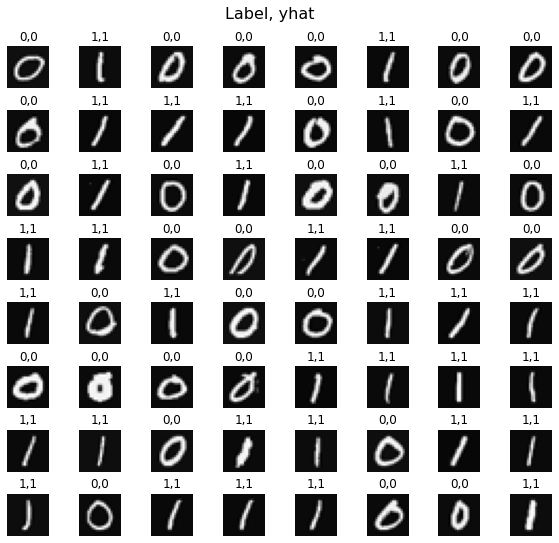

In [79]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# You do not need to modify anything in this cell

m, n = X.shape

fig, axes = plt.subplots(8,8, figsize=(8,8))
fig.tight_layout(pad=0.1,rect=[0, 0.03, 1, 0.92]) #[left, bottom, right, top]

for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20,20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
    
    # Predict using the Neural Network
    prediction = model.predict(X[random_index].reshape(1,400))
    if prediction >= 0.5:
        yhat = 1
    else:
        yhat = 0
    
    # Display the label above the image
    ax.set_title(f"{y[random_index,0]},{yhat}")
    ax.set_axis_off()
fig.suptitle("Label, yhat", fontsize=16)
plt.show()

### 2.5 NumPy Model Implementation (Forward Prop in NumPy)
It is possible to build your own dense layer using NumPy. This can then be utilized to build a multi-layer neural network. 

In [80]:
def my_dense(a_in, W, b, g):
    """
    Computes dense layer
    Args:
      a_in (ndarray (n, )) : Data, 1 example 
      W    (ndarray (n,j)) : Weight matrix, n features per unit, j units
      b    (ndarray (j, )) : bias vector, j units  
      g    activation function (e.g. sigmoid, relu..)
    Returns
      a_out (ndarray (j,))  : j units
    """
    units = W.shape[1]
    a_out = np.zeros(units)
    for j in range(units):             
        w = W[:,j]                     
        z = np.dot(w, a_in) + b[j]     
        a_out[j] = g(z)                
    return(a_out)

In [81]:
# Quick Check
x_tst = 0.1*np.arange(1,3,1).reshape(2,)  # (1 examples, 2 features)
W_tst = 0.1*np.arange(1,7,1).reshape(2,3) # (2 input features, 3 output features)
b_tst = 0.1*np.arange(1,4,1).reshape(3,)  # (3 features)
A_tst = my_dense(x_tst, W_tst, b_tst, sigmoid)
print(A_tst)

[0.54735762 0.57932425 0.61063923]


In [82]:
# UNIT TESTS

test_c2(my_dense)

All tests passed!


The following cell builds a three-layer neural network utilizing the `my_dense` subroutine above.

In [83]:
def my_sequential(x, W1, b1, W2, b2, W3, b3):
    a1 = my_dense(x,  W1, b1, sigmoid)
    a2 = my_dense(a1, W2, b2, sigmoid)
    a3 = my_dense(a2, W3, b3, sigmoid)
    return(a3)

We can copy trained weights and biases from Tensorflow.

In [84]:
W1_tmp,b1_tmp = layer1.get_weights()
W2_tmp,b2_tmp = layer2.get_weights()
W3_tmp,b3_tmp = layer3.get_weights()

In [85]:
# make predictions
prediction = my_sequential(X[0], W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp )
if prediction >= 0.5:
    yhat = 1
else:
    yhat = 0
print( "yhat = ", yhat, " label= ", y[0,0])
prediction = my_sequential(X[500], W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp )
if prediction >= 0.5:
    yhat = 1
else:
    yhat = 0
print( "yhat = ", yhat, " label= ", y[500,0])

yhat =  0  label=  0
yhat =  1  label=  1


Run the following cell to see predictions from both the Numpy model and the Tensorflow model. This takes a moment to run.

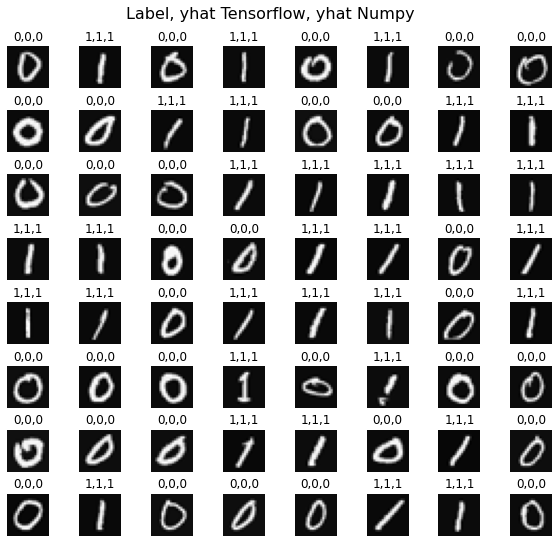

In [86]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# You do not need to modify anything in this cell

m, n = X.shape

fig, axes = plt.subplots(8,8, figsize=(8,8))
fig.tight_layout(pad=0.1,rect=[0, 0.03, 1, 0.92]) #[left, bottom, right, top]

for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20,20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')

    # Predict using the Neural Network implemented in Numpy
    my_prediction = my_sequential(X[random_index], W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp )
    my_yhat = int(my_prediction >= 0.5)

    # Predict using the Neural Network implemented in Tensorflow
    tf_prediction = model.predict(X[random_index].reshape(1,400))
    tf_yhat = int(tf_prediction >= 0.5)
    
    # Display the label above the image
    ax.set_title(f"{y[random_index,0]},{tf_yhat},{my_yhat}")
    ax.set_axis_off() 
fig.suptitle("Label, yhat Tensorflow, yhat Numpy", fontsize=16)
plt.show()

### 2.6 Vectorized NumPy Model Implementation (Optional)
Vector and matrix operations can be used to speed the calculations.

In [87]:
x = X[0].reshape(-1,1)         # column vector (400,1)
z1 = np.matmul(x.T,W1) + b1    # (1,400)(400,25) = (1,25)
a1 = sigmoid(z1)
print(a1.shape)

(1, 25)


You can take this a step further and compute all the units for all examples in one Matrix-Matrix operation.

The full operation is $\mathbf{Z}=\mathbf{XW}+\mathbf{b}$. This will utilize NumPy broadcasting to expand $\mathbf{b}$ to $m$ rows. If this is unfamiliar, a short tutorial is provided at the end of the notebook.

In [88]:
# UNQ_C3
# UNGRADED FUNCTION: my_dense_v

def my_dense_v(A_in, W, b, g):
    """
    Computes dense layer
    Args:
      A_in (ndarray (m,n)) : Data, m examples, n features each
      W    (ndarray (n,j)) : Weight matrix, n features per unit, j units
      b    (ndarray (1,j)) : bias vector, j units  
      g    activation function (e.g. sigmoid, relu..)
    Returns
      A_out (tf.Tensor or ndarray (m,j)) : m examples, j units
    """
    Z = np.matmul(A_in,W) + b    
    A_out = g(Z)                 
    return(A_out)

In [89]:
X_tst = 0.1*np.arange(1,9,1).reshape(4,2) # (4 examples, 2 features)
W_tst = 0.1*np.arange(1,7,1).reshape(2,3) # (2 input features, 3 output features)
b_tst = 0.1*np.arange(1,4,1).reshape(1,3) # (1,3 features)
A_tst = my_dense_v(X_tst, W_tst, b_tst, sigmoid)
print(A_tst)

[[0.54735762 0.57932425 0.61063923]
 [0.57199613 0.61301418 0.65248946]
 [0.5962827  0.64565631 0.6921095 ]
 [0.62010643 0.67699586 0.72908792]]


In [90]:
# UNIT TESTS

test_c3(my_dense_v)

All tests passed!


The following cell builds a three-layer neural network utilizing the `my_dense_v` subroutine above.

In [91]:
def my_sequential_v(X, W1, b1, W2, b2, W3, b3):
    A1 = my_dense_v(X,  W1, b1, sigmoid)
    A2 = my_dense_v(A1, W2, b2, sigmoid)
    A3 = my_dense_v(A2, W3, b3, sigmoid)
    return(A3)

We can again copy trained weights and biases from Tensorflow.

In [92]:
W1_tmp,b1_tmp = layer1.get_weights()
W2_tmp,b2_tmp = layer2.get_weights()
W3_tmp,b3_tmp = layer3.get_weights()

Let's make a prediction with the new model. This will make a prediction on *all of the examples at once*. Note the shape of the output.

In [93]:
Prediction = my_sequential_v(X, W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp )
Prediction.shape

(1000, 1)

We'll apply a threshold of 0.5 as before, but to all predictions at once.

In [94]:
Yhat = (Prediction >= 0.5).astype(int)
print("predict a zero: ",Yhat[0], "predict a one: ", Yhat[500])

predict a zero:  [0] predict a one:  [1]


Run the following cell to see predictions. This will use the predictions we just calculated above. This takes a moment to run.

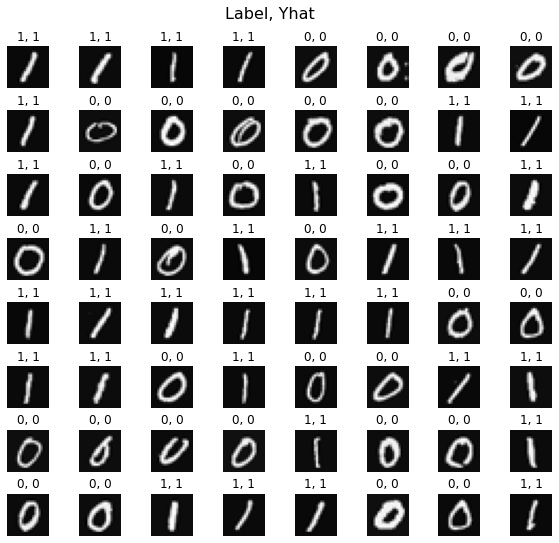

In [95]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# You do not need to modify anything in this cell

m, n = X.shape

fig, axes = plt.subplots(8, 8, figsize=(8, 8))
fig.tight_layout(pad=0.1, rect=[0, 0.03, 1, 0.92]) #[left, bottom, right, top]

for i, ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20, 20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
   
    # Display the label above the image
    ax.set_title(f"{y[random_index,0]}, {Yhat[random_index, 0]}")
    ax.set_axis_off() 
fig.suptitle("Label, Yhat", fontsize=16)
plt.show()

You can see how one of the misclassified images looks.

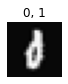

In [96]:
fig = plt.figure(figsize=(1, 1))
errors = np.where(y != Yhat)
random_index = errors[0][0]
X_random_reshaped = X[random_index].reshape((20, 20)).T
plt.imshow(X_random_reshaped, cmap='gray')
plt.title(f"{y[random_index,0]}, {Yhat[random_index, 0]}")
plt.axis('off')
plt.show()

In [97]:
a = np.array([1,2,3]).reshape(-1,1)  #(3,1)
b = 5
print(f"(a + b).shape: {(a + b).shape}, \na + b = \n{a + b}")

(a + b).shape: (3, 1), 
a + b = 
[[6]
 [7]
 [8]]


Note that this applies to all element-wise operations:

In [98]:
a = np.array([1,2,3]).reshape(-1,1)  #(3,1)
b = 5
print(f"(a * b).shape: {(a * b).shape}, \na * b = \n{a * b}")

(a * b).shape: (3, 1), 
a * b = 
[[ 5]
 [10]
 [15]]


In [99]:
a = np.array([1,2,3,4]).reshape(-1,1)
b = np.array([1,2,3]).reshape(1,-1)
print(a)
print(b)
print(f"(a + b).shape: {(a + b).shape}, \na + b = \n{a + b}")

[[1]
 [2]
 [3]
 [4]]
[[1 2 3]]
(a + b).shape: (4, 3), 
a + b = 
[[2 3 4]
 [3 4 5]
 [4 5 6]
 [5 6 7]]
